# Assignment 2
## Analyzing cardiovascular disease data  

In this assignment, you will answer questions about a dataset on cardiovascular disease. There are some tasks that will require you to write code. 

#### Problem: Predict the presence or absence of cardiovascular disease (CVD) using the patient examination results.

#### Data description: There are 3 types of input features:

- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.

| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Age | Objective Feature | age | int (days) |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Gender | Objective Feature | gender | categorical code |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

Let's get to know our data by performing a preliminary data analysis.

#  Part 1. Preliminary data analysis

In [1]:
#Import all required modules
import pandas as pd
import numpy as np

#Disable warnings
import warnings
warnings.filterwarnings("ignore")

#Import plotting modules
import seaborn as sns
sns.set()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

You will use the `seaborn` library for visual analysis, so let's set that up too:

In [2]:
# Tune the visual settings for figures in `seaborn`
sns.set_context("notebook", 
                font_scale=1.5,       
                rc={ "figure.figsize": (11, 8),  "axes.titlesize": 18})

from matplotlib import rcParams
rcParams["figure.figsize"] = 11, 8

To make it simple, we will work only with the training part of the dataset:

In [3]:
data = pd.read_csv("C:\\Users\\34609\\Desktop\\Hacer y subir a GitHub\\mlbootcamp5_train.csv", sep = ";")
print("Dataset size: ", data.shape) #Means we have 70k rows and 13 columns
data.head()

Dataset size:  (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


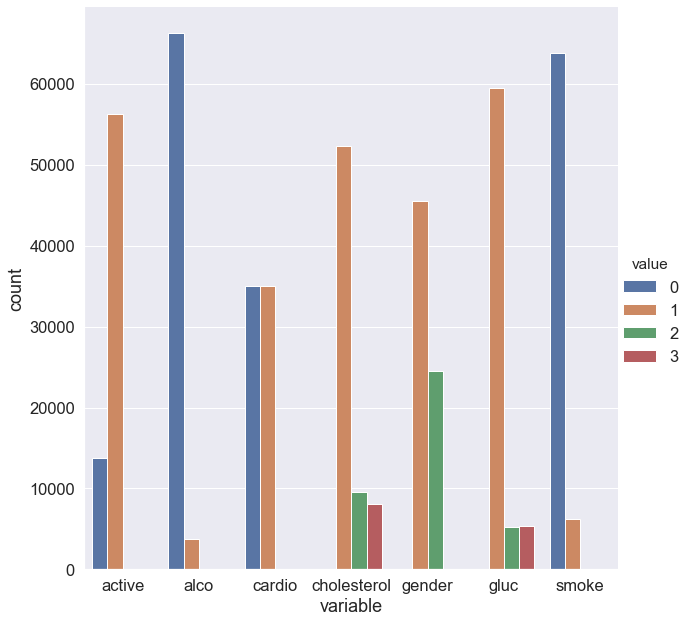

In [4]:
#Visual visualization of the data would help with understanding the data, the variables and how them can help solving the problem
data_uniques = pd.melt(frame = data, value_vars = ["gender","cholesterol", "gluc", "smoke", "alco", "active", "cardio"]) #pd.melt() pivot DFs
data_uniques = pd.DataFrame(data_uniques.groupby(["variable", "value"])["value"].count()) \
    .sort_index(level = [0, 1]) \
    .rename(columns = {"value": "count"}) \
    .reset_index()

sns.factorplot(x = "variable", y = "count", hue = "value", data = data_uniques, kind = "bar", size = 9);

#With this last chunk of code we are grouping the data by variables(columns), extracting the unique values of each one, assigning categories and counting the number of each one of them.

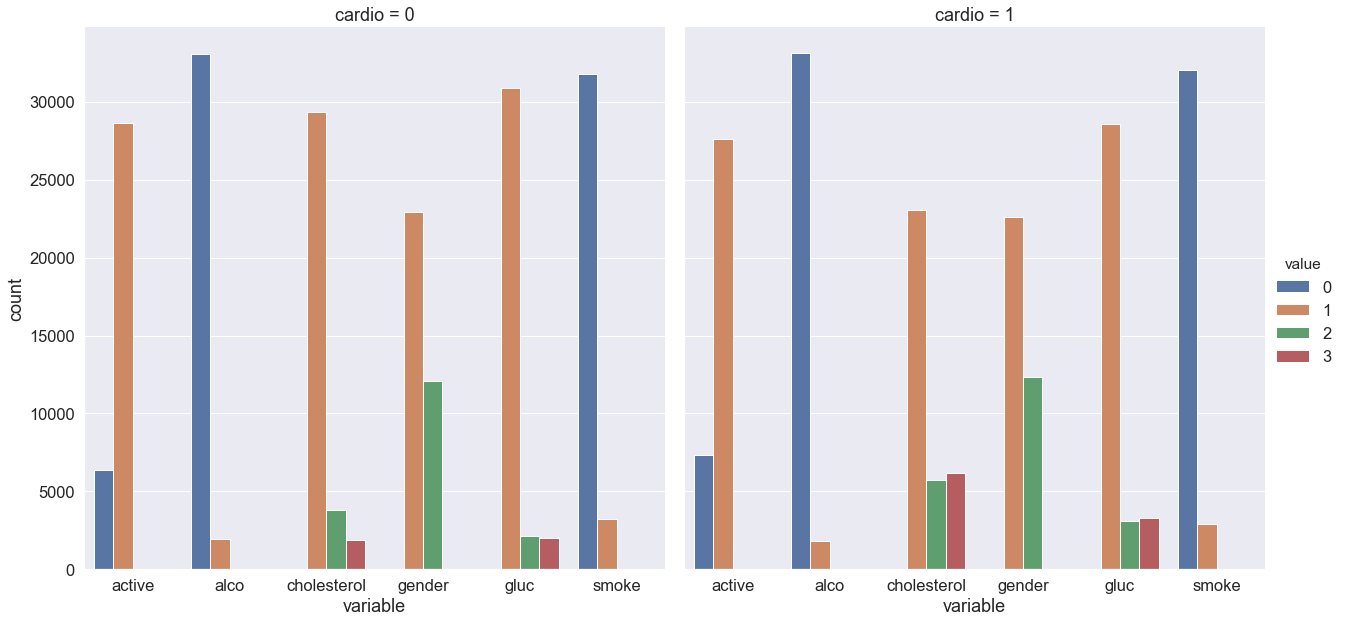

In [5]:
data_uniques = pd.melt(frame = data, 
                       value_vars = ["gender","cholesterol","gluc", "smoke", "alco", "active"], 
                       id_vars = ["cardio"])
data_uniques = pd.DataFrame(data_uniques.groupby(["variable", "value", "cardio"])["value"].count()) \
    .sort_index(level = [0, 1]) \
    .rename(columns = {"value" : "count"}) \
    .reset_index()

sns.factorplot(x = "variable", y = "count", hue = "value", 
               col = "cardio", data = data_uniques, kind ="bar", size = 9);
#The data in these plots shows that both groups look homogeniuos.
#It also reveals that there are differences in cholesterol and glucose and the presence of Cardiovascular Disease                

In [7]:
#Time for visualization of some statistical information about the variables stored in our dataset
for c in data.columns:
    n = data[c].nunique() #.nunique() returns the number of unique values
    print(c)
    if n <= 3:
        print(n, sorted(data[c].value_counts().to_dict().items())) #show uniques categories number, and the value_counts of each as a dictionary 
    else:
        print(n)
    print("      ") #used to separate categories indentify in the for-loop

id
70000
      
age
8076
      
gender
2 [(1, 45530), (2, 24470)]
      
height
109
      
weight
287
      
ap_hi
153
      
ap_lo
157
      
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
      
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
      
smoke
2 [(0, 63831), (1, 6169)]
      
alco
2 [(0, 66236), (1, 3764)]
      
active
2 [(0, 13739), (1, 56261)]
      
cardio
2 [(0, 35021), (1, 34979)]
      


## 1.1. Basic observations
**Question 1.1. (1 point). How many men and women are present in this dataset? Values of the `gender` feature were not given (whether "1" stands for women or for men) – figure this out by looking analyzing height, making the assumption that men are taller on average.**
1. 45530 women and 24470 men
2. 45530 men and 24470 women
3. 45470 women and 24530 men
4. 45470 men and 24530 women

In [8]:
#If we make the assumption than, in average, men are taller than women:
mean_height = data.groupby("gender")["height"].mean()
mean_height

gender
1    161.355612
2    169.947895
Name: height, dtype: float64

In [9]:
#2 stands for men, while 1 represents women. So:
print("Women ", data[data["gender"] == 1]["gender"].count())
print("Men ", data[data["gender"] == 2]["gender"].count())
#Correct answer 1

Women  45530
Men  24470


**Question 1.2. (1 point). Which gender more often reports consuming alcohol - men or women?**
1. women
2. men

In [10]:
#2 stands for men, while 1 represents women. So:
alco_men = round(data[data["gender"] == 2]["alco"].mean(), 3)
alco_women = round(data[data["gender"] == 1]["alco"].mean(), 3)
print("Mean alcohol for women: ", alco_women, "and mean alcohol for men: ", alco_men)
#Correct answer 2

Mean alcohol for women:  0.025 and mean alcohol for men:  0.106


**Question 1.3. (1 point). What is the difference between the percentages of smokers among men and women (rounded)?**
1. 4
2. 16
3. 20
4. 24

In [11]:
#Men == 2 & Women == 1;
women_smokers = data.loc[data["gender"] == 1, "smoke"].value_counts(normalize=True) * 100
men_smokers = data.loc[data["gender"] == 2, "smoke"].value_counts(normalize=True) * 100
diff_smokers = round(abs(men_smokers - women_smokers), 3)
print("Difference between smokers for men and woman ", diff_smokers)

Difference between smokers for men and woman  0    20.102
1    20.102
Name: smoke, dtype: float64


**Question 1.4. (1 point). What is the difference between median values of age for smokers and non-smokers (in months, rounded)? You'll need to figure out the units of feature `age` in this dataset.** 1. 5 2. 10 3. 15 4. 20

In [12]:
max_age = data["age"].max()
min_age = data["age"].min()
print("max_age", max_age, "min_age", min_age, "in unknown units")
#If years, it would be impossible. If months max_age would be divided by 12 and if in days, it would be divided by 365, lets try both options.

max_age_months = max_age/12 
max_age_days = max_age/365
print(round(max_age_months, 2)) #Example of age in years if initial unit was months
print(round(max_age_days, 2)) #Example of age in years if initial unit was days
#Age is in days!!!

max_age 23713 min_age 10798 in unknown units
1976.08
64.97


In [13]:
smokers = data[data["smoke"] == 1]["age"].median() #Age in days
non_smokers = data[data["smoke"] == 0]["age"].median() #Age in days
diff_mean_age = abs(round((smokers - non_smokers)/30))
print("Difference between median values of age for smokers and non-smokers", diff_mean_age, "is months.")

Difference between median values of age for smokers and non-smokers 20 is months.


## 1.2. Risk maps
### Task:
On the website for the European Society of Cardiology, a [SCORE scale](https://www.escardio.org/Education/Practice-Tools/CVD-prevention-toolbox/SCORE-Risk-Charts) is provided. It is used for calculating the risk of death from a cardiovascular decease in the next 10 years.


Let's take a look at the upper-right rectangle, which shows a subset of smoking men aged from 60 to 65. (It's not obvious, but the values in the figure represent the upper bound).

We see the value 9 in the lower-left corner of the rectangle and 47 in the upper-right. This means that, for people in this gender-age group whose systolic pressure is less than 120, the risk of a CVD is estimated to be 5 times lower than for those with the pressure in the interval [160,180). Let's calculate that ratio using our data.

Clarifications:
- Calculate ``age_years`` feature – round age to the nearest number of years. For this task, select only the people of age 60 to 64, inclusive.
- Cholesterol level categories differ between the figure and our dataset. The conversion for the ``cholesterol`` feature is as follows: 4 mmol/l $\rightarrow$ 1, 5-7 mmol/l $\rightarrow$ 2, 8 mmol/l $\rightarrow$ 3.

In [14]:
data["age_years"] = round(data["age"]/365.25).astype("int")

#For filtering the subset of MEN between 60 and 65 and smokers, we need to used 4 masks.
smok_men_subset = data[(data["gender"] == 2) & (data["age_years"] < 65) & (data["age_years"] >= 60) & (data["smoke"] == 1)]
ratio = smok_men_subset.shape[0] / data.shape[0] #for ratio calculation we only count the number os rows on each DF
print("Ratio of old smoker men among the total are ", ratio)

Ratio of old smoker men among the total are  0.0141


## 1.3. Analyzing BMI
### Task:
Create a new feature – BMI ([Body Mass Index](https://en.wikipedia.org/wiki/Body_mass_index)). To do this, divide weight in kilogramms by the square of the height in meters. Normal BMI values are said to be from 18.5 to 25. 

In [15]:
data["bmi"] = data["weight"] / (data["height"]/100)**2
data["bmi"].describe()

count    70000.000000
mean        27.556513
std          6.091511
min          3.471784
25%         23.875115
50%         26.374068
75%         30.222222
max        298.666667
Name: bmi, dtype: float64

**Question 1.6. (2 points). Choose the correct statements:**

1. Median BMI in the sample is within the range of normal BMI values. 

In [16]:
normal_BMI_subset = data[(data["bmi"] >= 18.5) & data["bmi"] <= 25] 
round(normal_BMI_subset["bmi"].median(), 3)

26.374

2. The BMI for women is on average higher than for men. 

In [17]:
#Men == 2 & Women == 1;
data.groupby("gender")["bmi"].mean()
 #here we get results printed and decission can be made uppon of them. Answer is True. 

gender
1    27.987583
2    26.754442
Name: bmi, dtype: float64

In [18]:
#Here we do an automatic process to search the answer
bmi_women = data[data["gender"] == 1]["bmi"].mean()
bmi_men = data[data["gender"] == 2]["bmi"]. mean()
if bmi_women > bmi_men:
    print("True")
elif bmi_men > bmi_women:
    print("False")
else:
    print("Error")        

True


3. Healthy people have, on average, a higher BMI than the people with CVD. 

In [19]:
#Healty means cardio = 0 and people with CVD means cardio = 1. 
healty = data[data["cardio"] == 0]["bmi"].mean() #average value of bmi for healthy people
non_healty = data[data["cardio"] == 1]["bmi"].mean() #same but for poeple with CVDs
if healty > non_healty:
    print("True")
elif healty < non_healty:
    print("False")
else:
    print("Error")

False


4. For healthy, non-drinking men, BMI is closer to the norm than for healthy, non-drinking women

In [20]:
healty_men = data[(data["cardio"] == 0) & (data["gender"] == 2) & (data["alco"] == 0)]["bmi"].mean()
healty_women = data[(data["cardio"] == 0) & (data["gender"] == 1) & (data["alco"] == 0)]["bmi"].mean()
print("Healty men BMI average value is ", round(healty_men, 3), "while women's value is ", round(healty_women, 3))
if (healty_men - 25) < (healty_women - 25):
    print("True")
elif (healty_men - 25) > (healty_women - 25):
    print("False")
else:
    print("Error")    

Healty men BMI average value is  25.873 while women's value is  26.845
True


## 1.4. Cleaning data
### Task:
We can see that the data is not perfect. It contains "dirt" and inaccuracies. We'll see this better as we visualize the data.

Filter out the following patient segments (we consider these as erroneous data)

- diastolic pressure is higher than systolic 
- height is strictly less than 2.5 percentile (Use `pd.Series.quantile` to compute this value. If you are not familiar with the function, please read the docs.)
- height is strictly more than 97.5 percentile
- weight is strictly less than 2.5 percentile
- weight is strictly more than 97.5 percentile

This is not everything that we can do to clean this data, but this is sufficient for now.

In [21]:
clean_data = data[(data["height"] >= data["height"].quantile(0.025)) & (data["height"] <= data["height"].quantile(0.975))] #elimination of the 2 tails of n-distri
clean_data = data[(data["weight"] >= data["weight"].quantile(0.025)) & (data["weight"] <= data["weight"].quantile(0.975))] #elimination of the 2 tails of n-distri
clean_data = data[(data["ap_hi"] > data["ap_lo"])] #elimination of wrong blood preassures data

**Question 1.7. (2 points). What percent of the original data (rounded) did we throw away?**

1. 8 ; 2. 9 ; 3. 10 ; 4. 11

In [22]:
data_eliminated = round((1 - clean_data.shape[0] / data.shape[0]) * 100, 0)
print("Percentage of data cleaned: ", data_eliminated, "%")

Percentage of data cleaned:  2.0 %


# Part 2. Visual data analysis

## 2.1. Correlation matrix visualization

To understand the features better, you can create a matrix of the correlation coefficients between the features. Use the initial dataset (non-filtered).

### Task:

Plot a correlation matrix using [`heatmap()`](http://seaborn.pydata.org/generated/seaborn.heatmap.html). You can create the matrix using the standard `pandas` tools with the default parameters.

** Question 2.1. (1 point).** Which pair of features has the strongest Pearson's correlation with the *gender* feature?

1. Cardio, Cholesterol ; 2. Height, Smoke ; 3. Smoke, Alco ; 4. Height, Weight

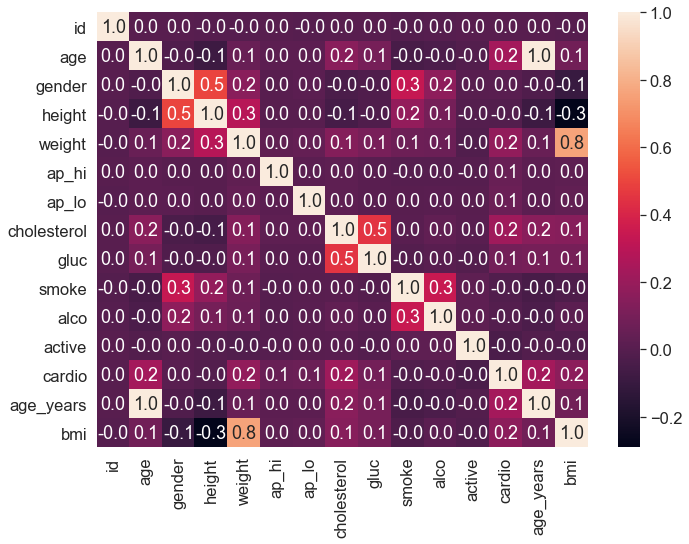

In [40]:
data_corr = data.corr(method = "pearson")
sns.heatmap(data = data_corr, annot = True, fmt = ".1f");

In [ ]:
#According with the heatmap, the answer is 2 --> Height with (0.5) and smoke with (0.3)

**Question 2.2. (1 point).** Which pair of features has the strongest Spearman correlation?

1. Height, Weight ; 2. Age, Weight ; 3. Cholesterol, Gluc ; 4. Cardio, Cholesterol ; 5. Ap_hi, Ap_lo ; 6. Smoke, Alco

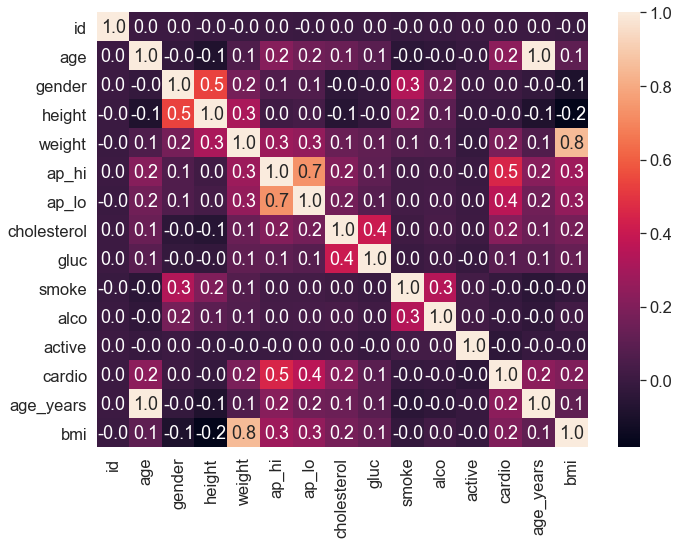

In [41]:
data_corr = data.corr(method = "spearman")
sns.heatmap(data = data_corr, annot = True, fmt = ".1f");

In [ ]:
#According with the heatmap, the answer is 5 --> Ap_hi and Ap_lo with (0.7)

**Question 2.3. (1 point).** Why do these features have strong rank correlation?

1. Inaccuracies in the data (data acquisition errors). ; 2. Relation is wrong, these features should not be related. ; 3. Nature of the data.

In [ ]:
#Because the nature of the data

## 2.2. Height distribution of men and women

From our exploration of the unique values earlier, we know that the gender is encoded by the values *1* and *2*. Although you do not know the mapping of these values to gender, you can figure that out graphically by looking at the mean values of height and weight for each value of the *gender* feature.

### Task:

Create a violin plot for the height and gender using [`violinplot()`](https://seaborn.pydata.org/generated/seaborn.violinplot.html). Use the parameters:
- `hue` to split by gender;
- `scale` to evaluate the number of records for each gender.

In order for the plot to render correctly, you need to convert your `DataFrame` to *long* format using the `melt()` function from `pandas`. Here is [an example](https://stackoverflow.com/a/41575149/3338479) of this for your reference.

In [31]:
violin_data = pd.melt(data, value_vars = ["height"], id_vars = ["gender"], var_name = "Height", value_name = "cms")
violin_data.head(3)

,gender,Height,cms
0,2,height,168
1,1,height,156
2,1,height,165


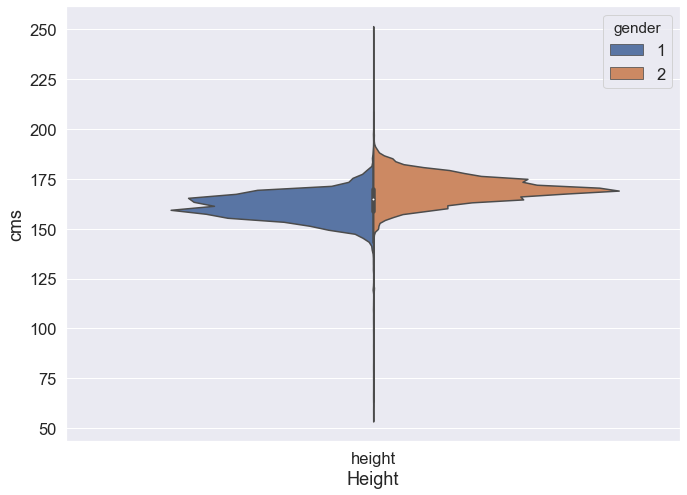

In [39]:
sns.violinplot(data = violin_data, x = "Height", y = "cms", hue = "gender", split = True, size = 3);

## 2.4. Age

Previously, we calculated the age of the respondents in years at the moment of examination.
### Task:

Create a *count plot* using [`countplot()`](http://seaborn.pydata.org/generated/seaborn.countplot.html) with the age on the *X* axis and the number of people on the *Y* axis. Your resulting plot should have two columns for each age, corresponding to the number of people for each *cardio* class of that age.

In [58]:
data_2_4 = pd.melt(frame = data, value_vars = ["age_years"], id_vars = ["cardio"])
data_2_4.head(3)

,cardio,variable,value
0,0,age_years,50
1,1,age_years,55
2,1,age_years,52


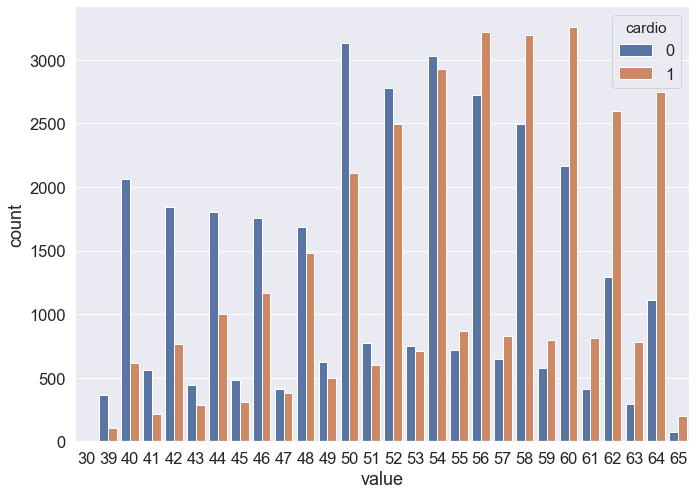

In [65]:
data_2_4 = pd.melt(frame = data, value_vars = ["age_years"], id_vars = ["cardio"])
sns.countplot(data = data_2_4, x = "value", hue = "cardio");

**Question 2.4. (1 point).** What is the smallest age at which the number of people with CVD outnumber the number of people without CVD?

1. 44 ; 2. 55 ; 3. 64 ; 4. 70

In [ ]:
#According with the above plot, the answer is 2, at the age of 55 years. 


    
Authors: [Ilya Baryshnikov](https://www.linkedin.com/in/baryshnikov-ilya/), [Maxim Uvarov](https://www.linkedin.com/in/maxis42/), and [Yury Kashnitsky](https://www.linkedin.com/in/festline/). Translated and edited by [Inga Kaydanova](https://www.linkedin.com/in/inga-kaidanova-a92398b1/), [Egor Polusmak](https://www.linkedin.com/in/egor-polusmak/), [Anastasia Manokhina](https://www.linkedin.com/in/anastasiamanokhina/), and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/). All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.